In [1]:
using LinearAlgebra
using Flux
using Random

In [2]:
n = 300
x0 = range(-2,length=n,stop=2) #Julia 1.0.0以降はlinspaceではなくこの書き方になった。
a0 = 3.0
a1= 2.0
b0 = 1.0
y0 = zeros(Float32,n)
f(x0) = a0.*x0 .+ a1.*x0.^2 .+ b0 .+ 3*cos.(20*x0)
y0[:] = f.(x0)

300-element Vector{Float64}:
  0.9991858150432145
  1.5948183517979828
  2.286427128276255
  3.020112659801983
  3.739032158696947
  4.387444553393177
  4.914677107753617
  5.278731369944965
  5.4492718460635725
  5.409784719959697
  ⋮
 16.80713137783615
 16.71685846024597
 16.43307175658305
 15.986106760751039
 15.417961924583235
 14.779309984216697
 14.125892011219399
 13.514550793269553
 12.999185815043214

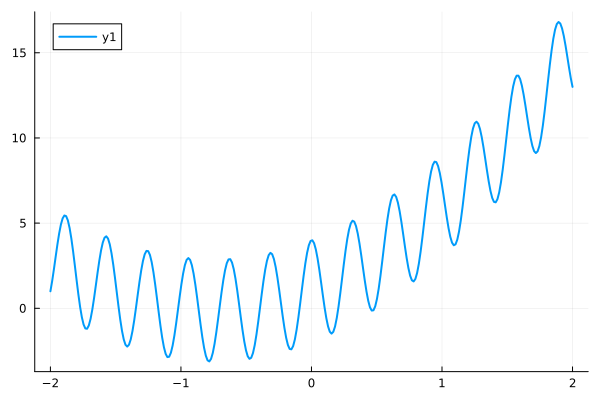

In [3]:
using Plots
plot(x0, y0, linewidth=2.0)

In [4]:
function make_φ(x0,n,k)
    φ = zeros(Float32,k,n)
    for i in 1:k
        φ[i,:] = x0.^(i-1)
    end
    return φ
end
k = 6
φ = make_φ(x0,n,k)

6×300 Matrix{Float32}:
   1.0    1.0        1.0      …   1.0       1.0       1.0       1.0
  -2.0   -1.98662   -1.97324      1.95987   1.97324   1.98662   2.0
   4.0    3.94667    3.89369      3.84108   3.89369   3.94667   4.0
  -8.0   -7.84054   -7.68321      7.52799   7.68321   7.84054   8.0
  16.0   15.5762    15.1608      14.7539   15.1608   15.5762   16.0
 -32.0  -30.944    -29.916    …  28.9156   29.916    30.944    32.0

In [5]:
d_input = k
d_middle = 10
d_output = 1
model = Chain(
    Dense(d_input, d_middle,σ), #一層目。活性化関数にreluを使用
    BatchNorm(d_middle), #バッチ正規化　
    Dense(d_middle, d_output) #二層目
    )

Chain(
  Dense(6 => 10, σ),                    # 70 parameters
  BatchNorm(10),                        # 20 parameters, plus 20
  Dense(10 => 1),                       # 11 parameters
)         # Total: 6 trainable arrays, 101 parameters,
          # plus 2 non-trainable, 20 parameters, summarysize 972 bytes.

In [6]:
Flux.testmode!(model) #Batchの平均と分散を更新しないようにする。つまりテストモード。
println("model 2 inputs: ",model(φ[:,1:2]))
Flux.testmode!(model,false) #テストモードを終了する。

model 2 inputs: Float32

[0.46765906 0.46791527]


Chain(
  Dense(6 => 10, σ),                    # 70 parameters
  BatchNorm(10, active=true),           # 20 parameters, plus 20
  Dense(10 => 1),                       # 11 parameters
)         # Total: 6 trainable arrays, 101 parameters,
          # plus 2 non-trainable, 20 parameters, summarysize 973 bytes.

In [7]:
loss(x, y) =  sum([(y[i] .- model(x)[i]).^2 for i=1:length(y) ])/length(y)

loss (generic function with 1 method)

In [8]:
opt = ADAM()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [9]:
function make_random_batch(x,y,batchsize)
    numofdata = length(y)
    A = shuffle(1:numofdata)[1:batchsize]
    xdata = x[:,1:batchsize]
    ydata = y[1:batchsize]
    for i=1:batchsize
        xdata[:,i] = x[:,A[i]]
        ydata[i] = y[A[i]]
    end
    data = [(xdata,ydata)]
    return data
end

make_random_batch (generic function with 1 method)

In [12]:
function train_batch!(xtest,ytest,model,nt,batchsize)
    for it=1:nt
        data = make_random_batch(xtest,ytest,batchsize) #ランダムバッチを作る
        Flux.train!(loss, Flux.params(model),data, opt) #学習
        #Flux.train!(loss, data, opt) #学習
        if it% 100 == 0
            Flux.testmode!(model) #テストモードへ。
            lossvalue = 0.0
            #lossvalue += loss(xtest[:,:],ytest[:]).data #テストデータとの誤差
            lossvalue += loss(xtest[:,:],ytest[:]) #テストデータとの誤差
            println("$(it)-th loss = ",lossvalue)
            Flux.testmode!(model,false) #テストモード終了。
        end
    end
end

train_batch! (generic function with 1 method)

In [13]:
batchsize =20 #バッチサイズ
nt = 3000 #学習の回数
train_batch!(φ,y0,model,nt,batchsize)

100-th loss = 25.395944595336914
200-th loss = 

14.905075073242188


300-th loss = 10.24134349822998
400-th loss = 

15.176274299621582


500-th loss = 5.9486565589904785
600-th loss = 

5.4575724601745605


700-th loss = 5.16102933883667
800-th loss = 

6.569853782653809


900-th loss = 5.024906635284424
1000-th loss = 

5.672364711761475


1100-th loss = 4.747734069824219
1200-th loss = 

4.863516330718994


1300-th loss = 5.622803211212158
1400-th loss = 

8.626916885375977


1500-th loss = 4.903875350952148
1600-th loss = 

4.631282806396484


1700-th loss = 4.554435729980469
1800-th loss = 

4.629708290100098


1900-th loss = 5.2086262702941895
2000-th loss = 

5.148993968963623


2100-th loss = 4.96152400970459
2200-th loss = 

4.625479221343994


2300-th loss = 5.517297267913818
2400-th loss = 

6.240910053253174


2500-th loss = 4.6400275230407715
2600-th loss = 

5.021411418914795


2700-th loss = 4.839906215667725
2800-th loss = 

4.498444080352783


2900-th loss = 4.485634803771973
3000-th loss = 

4.718443870544434


In [25]:
Flux.testmode!(model) #テストモードへ。
ye = model(φ)#[model(φ[:,i]).data[1] for i=1:length(y0)]
Flux.testmode!(model,false) #テストモード終了

Chain(
  Dense(6 => 10, σ),                    # 70 parameters
  BatchNorm(10, active=true),           # 20 parameters, plus 20
  Dense(10 => 1),                       # 11 parameters
)         # Total: 6 trainable arrays, 101 parameters,
          # plus 2 non-trainable, 20 parameters, summarysize 973 bytes.

In [28]:
y1 = [ye[1,i] for i in 1:300]

300-element Vector{Float32}:
  5.135273
  5.0359735
  4.924842
  4.802347
  4.6693764
  4.52722
  4.3775096
  4.222126
  4.06312
  3.9025695
  ⋮
 14.223755
 14.39422
 14.56723
 14.74272
 14.920596
 15.100737
 15.282977
 15.467131
 15.652966

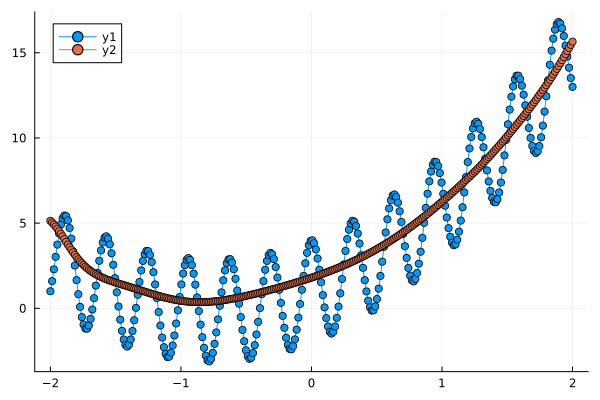

In [29]:
plot(x0,y0,marker=:circle)
plot!(x0,y1,marker=:circle)
